In [1]:
import tensorflow as tf
import numpy as np
import numpy.random as rng
import pandas as pd
import os, pdb, re
import string
import stats

from keras import utils
float_formatter = lambda x: "%.2f" % x
np.set_printoptions(linewidth=200,threshold=np.nan,formatter={'float_kind':float_formatter})
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option("display.max_colwidth",200)
pd.set_option("display.max_rows",200)
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#Preprocessing
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import keras.preprocessing.text as text
from keras.preprocessing import sequence

/Users/matt/kaggle/movie_sent/venv/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
MAX_WORD_COUNT = 60
N_OUT = 5
BATCH_SIZE = 5
HIDDEN_SIZE = 32
NUM_LAYERS = 2
INIT_SCALE = 0.05

In [3]:
def sentence_clean( sentence ):
    review_text = BeautifulSoup(sentence).get_text() # 1. Remove HTML  
    letters_only = re.sub("[^a-zA-Z]", " ", sentence) #Remove non-letters
    words = letters_only.lower().split()    #Convert to lower case, split into individual words                          
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] #Remove stop words
    return( " ".join( meaningful_words )) #Join the words back into one string separated by space

# The Love Song of J. Alfred Prufrock

In [4]:
def prufrock_df():
    df = pd.read_table("The Love Song of J. Alfred Prufrock.txt",header=None,names=["Line"],dtype={"Line":str})
    txt = df["Line"].values
    df_clean = list(map(sentence_clean,txt))
    return df_clean
    #pd.DataFrame({"before":txt,"after":df_clean})

# Wiki text

In [5]:
with open('/Users/matt/gensim-data/text8/text8') as f:
    txt8_data = f.read()
    print(len(txt8_data))
    f.close()

100000000


In [6]:
txt8_data = txt8_data[:1000000]
txt8_data_clean = sentence_clean(txt8_data)

/Users/matt/kaggle/movie_sent/venv/lib/python3.5/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html5lib"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 184 of the file /Users/matt/anaconda/lib/python3.5/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "html5lib")

  markup_type=markup_type))


In [7]:
class Data_obj():
    def __init__(self,batch_size,clean_data):
        self.epoch = 1
        self.batch_size = batch_size
        self.clean_data = clean_data
        
        self.Tokenizer = text.Tokenizer()
        self.Tokenizer.fit_on_texts(clean_data)
        self.words = self.Tokenizer.word_index.keys()
        self.encoded_text = self.Tokenizer.texts_to_sequences(self.clean_data)[0]
        
        self.inverse_tokenizer = lambda num: list(self.Tokenizer.word_index.keys())[list(self.Tokenizer.word_index.values()).index(num)] #inverse
        self.inverse_tokenizer_sentence = lambda sentence: list(map(self.inverse_tokenizer,sentence))
        
        self.vocab_size = len(self.Tokenizer.word_index) + 1
        print("There are {0} unique words in data set.".format(self.vocab_size))
           
    def new_batch(self):
        return np.zeros((self.batch_size,2)).astype(np.int32)
    
    def generator(self):
        self.i = self.k = 0
        batch = self.new_batch()
        self.total_examples_seen = 0
        while True:
            n_words = len(self.encoded_text)
            for j in range(n_words):
                context = self.encoded_text[j]
                if j == 0:
                    target = self.encoded_text[j+1]
                elif j == n_words - 1:
                    target = self.encoded_text[j-1]
                elif rng.uniform() < 0.5:
                    target = self.encoded_text[j-1]
                else:
                    target = self.encoded_text[j+1]
                    
                batch[self.k,0] = context
                batch[self.k,1] = target
                if self.k == BATCH_SIZE - 1:
                    self.k = 0
                    yield batch
                    batch = self.new_batch()
                    self.total_examples_seen += self.batch_size
                else:
                    self.k += 1

            self.epoch += 1

In [8]:
data_obj = Data_obj(batch_size=BATCH_SIZE,clean_data=[txt8_data_clean])
generate_batch = data_obj.generator()
for i in range(3):
    data = next(generate_batch)
    for i in data:
        print(i,data_obj.inverse_tokenizer_sentence(i))

There are 16634 unique words in data set.
[  70 1974] ['anarchism', 'originated']
[1974   70] ['originated', 'anarchism']
[ 160 1283] ['term', 'abuse']
[1283  160] ['abuse', 'term']
[18 27] ['first', 'used']
[27 18] ['used', 'first']
[ 48 449] ['early', 'working']
[449  48] ['working', 'early']
[ 491 2225] ['class', 'radicals']
[2225  491] ['radicals', 'class']
[  66 2225] ['including', 'radicals']
[6093   66] ['diggers', 'including']
[ 172 6093] ['english', 'diggers']
[533 172] ['revolution', 'english']
[8716 8717] ['sans', 'culottes']


## Embedding layer - Turns positive integers (indexes) into dense vectors of fixed size”

In [9]:
vocabulary_size = data_obj.vocab_size
embedding_size = HIDDEN_SIZE
train_inputs = tf.placeholder(tf.int32, shape=[None])
train_context = tf.placeholder(tf.int32, shape=[None, 1])
embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

#NCE Loss
nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
hidden_out = tf.matmul(embed, tf.transpose(nce_weights)) + nce_biases
soft_max = tf.nn.softmax(hidden_out)
loss = tf.reduce_mean(
        tf.nn.nce_loss(weights=nce_weights,
                       biases=nce_biases,
                       labels=train_context,
                       inputs=embed,
                       num_sampled=1,
                       num_classes=vocabulary_size))
# Optimization 
learning_rate = tf.placeholder(tf.float32)
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
saver = tf.train.Saver()
model_path = "/tmp/model.ckpt"

#cosine similarity
embedding_norm=tf.nn.l2_normalize(embeddings,axis=1)
similarity = tf.matmul(embedding_norm, tf.transpose(embedding_norm))

In [14]:
load = True
with tf.Session() as sess:
    if load == True:
        saver.restore(sess,model_path)
    else:
        init = tf.global_variables_initializer()
        sess.run(init)
    embeddings_before = embeddings.eval()
    data_obj = Data_obj(batch_size=BATCH_SIZE,clean_data=[txt8_data_clean])
    generate_batch = data_obj.generator()
    cur_losses = []
    lr = 0.5
    while True:
        data = next(generate_batch)
        feed_dict = {train_inputs: data[:,0],train_context:data[:,[1]],learning_rate:lr}
        _, cur_loss = sess.run([optimizer, loss], feed_dict=feed_dict)
        cur_losses.append(cur_loss)
        if data_obj.total_examples_seen % 100000 == 0:
            print("{0} seen with running loss of {1:.3f}. Current epoch = {2}. Current lr = {3:.3f}".format(data_obj.total_examples_seen,np.mean(cur_losses),data_obj.epoch,lr))
            cur_losses = []
            lr /= 1.003
            save_path = saver.save(sess,model_path)
        if data_obj.epoch == 50:
            print("Finished.")
            break
    
    learnt_embeddings = embeddings.eval()

INFO:tensorflow:Restoring parameters from /tmp/model.ckpt
There are 16634 unique words in data set.
0 seen with running loss of 0.789. Current epoch = 1. Current lr = 0.500
100000 seen with running loss of 0.784. Current epoch = 1. Current lr = 0.499
200000 seen with running loss of 0.818. Current epoch = 2. Current lr = 0.497
300000 seen with running loss of 0.830. Current epoch = 3. Current lr = 0.496
400000 seen with running loss of 0.817. Current epoch = 4. Current lr = 0.494
500000 seen with running loss of 0.824. Current epoch = 5. Current lr = 0.493
600000 seen with running loss of 0.813. Current epoch = 6. Current lr = 0.491
700000 seen with running loss of 0.811. Current epoch = 7. Current lr = 0.490
800000 seen with running loss of 0.808. Current epoch = 8. Current lr = 0.488
900000 seen with running loss of 0.808. Current epoch = 9. Current lr = 0.487
1000000 seen with running loss of 0.798. Current epoch = 10. Current lr = 0.485
1100000 seen with running loss of 0.785. Curr

In [17]:
with tf.Session() as sess:
    saver.restore(sess,model_path)
    top_n_words = 3
    cosine_similarity = similarity.eval()
    for word_no in range(1,vocabulary_size)[:10]:
        word = data_obj.inverse_tokenizer(word_no)
        feed_dict={train_inputs:np.array([word_no])}
        word_embed, word_pred = sess.run([embed,soft_max],feed_dict)
        word_pred = word_pred.squeeze()
        top_n_args = word_pred.argsort()[-top_n_words:]
        print("\n")
        print(word,word_no)
        #print(word_pred)
        print(data_obj.inverse_tokenizer_sentence(top_n_args))

INFO:tensorflow:Restoring parameters from /tmp/model.ckpt


one 1
['nine', 'seven', 'six']


zero 2
['four', 'seven', 'six']


nine 3
['seven', 'six', 'one']


two 4
['five', 'six', 'alaska']


six 5
['four', 'seven', 'six']


three 6
['eight', 'four', 'six']


four 7
['alaska', 'six', 'nine']


five 8
['alaska', 'six', 'nine']


eight 9
['eight', 'one', 'six']


seven 10
['two', 'seven', 'six']


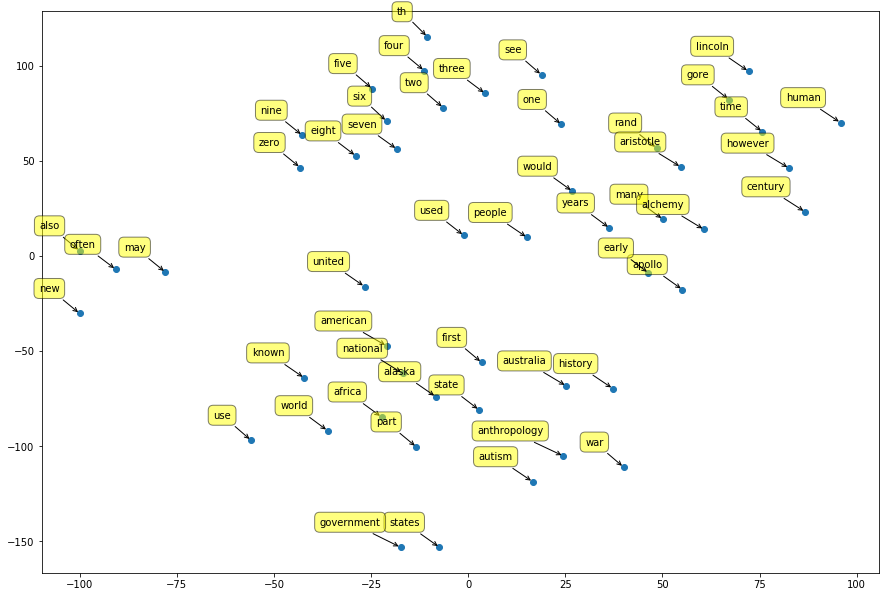

In [22]:
n_words_display = 50 # look at first n_words_display embedded
pca = TSNE(n_components=2,perplexity=5)
reduced_embeddings = pca.fit_transform(learnt_embeddings[1:n_words_display+1]) #first embedding is meaningless (cant index it)
labels = [data_obj.inverse_tokenizer(word_no) for word_no in range(1,vocabulary_size)[:n_words_display]]

plt.figure(figsize=(15,10))
plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    reduced_embeddings[:, 0], reduced_embeddings[:, 1], marker='o',
    cmap=plt.get_cmap('Spectral'))

for label, x, y in zip(labels, reduced_embeddings[:, 0], reduced_embeddings[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

plt.show()

In [ ]:
pca.explained_variance_ratio_